<a href="https://colab.research.google.com/github/AyeshaAnzer1610/Intelligent-AI-Agent-Framework-for-Continuous-Internal-Audit-in-Banking/blob/main/An_Intelligent_AI_Agent_Framework_for_Continuous_Internal_Audit_in_Banking_Evidence_from_Canadian_Financial_Fraud_and_Risk_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
import pandas as pd

DATA_URL = (
    "https://open.canada.ca/data/dataset/6a09c998-cddb-4a22-beff-4dca67ab892f/"
    "resource/43c67af5-e598-4a9b-a484-fe1cb5d775b5/download/"
    "cafc-open-gouv-database-2021-01-01-to-2025-09-30-extracted-2025-10-01.csv"
)

df = pd.read_csv(DATA_URL)

print("Shape:", df.shape)


Shape: (350361, 21)


In [10]:
for i, col in enumerate(df.columns):
    print(f"{i:02d}: {col}")


00: Numéro d'identification / Number ID
01: Date Received / Date reçue
02: Complaint Received Type
03: Type de plainte reçue
04: Country
05: Pays
06: Province/State
07: Province/État
08: Fraud and Cybercrime Thematic Categories
09: Catégories thématiques sur la fraude et la cybercriminalité
10: Solicitation Method
11: Méthode de sollicitation
12: Gender
13: Genre
14: Language of Correspondence
15: Langue de correspondance
16: Victim Age Range / Tranche d'âge des victimes
17: Complaint Type
18: Type de plainte
19: Number of Victims / Nombre de victimes
20: Dollar Loss /pertes financières


In [11]:
import pandas as pd

df_raw = df.copy()

df = df_raw[[
    "Numéro d'identification / Number ID",
    "Date Received / Date reçue",
    "Country",
    "Province/State",
    "Fraud and Cybercrime Thematic Categories",
    "Solicitation Method",
    "Complaint Type",
    "Number of Victims / Nombre de victimes",
    "Dollar Loss /pertes financières"
]].copy()

df.columns = [
    "record_id",
    "date_received",
    "country",
    "province",
    "fraud_category",
    "solicitation_method",
    "complaint_type",
    "num_victims",
    "amount_lost"
]

print(df.shape)
df.head(3)


(350361, 9)


,record_id,date_received,country,province,fraud_category,solicitation_method,complaint_type,num_victims,amount_lost
0,350308,2025-09-29,Canada,Ontario,Personal Info,Direct call,Victim,1,$0.00
1,350309,2025-09-29,Canada,Quebec,Identity Fraud,Other/unknown,Victim,1,$0.00
2,350310,2025-09-29,Canada,Quebec,Extortion,Direct call,Attempt,0,$0.00


In [13]:
df.info()
(df.isna().mean() * 100).sort_values(ascending=False)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350361 entries, 0 to 350360
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   record_id            350361 non-null  int64 
 1   date_received        350361 non-null  object
 2   country              350361 non-null  object
 3   province             350361 non-null  object
 4   fraud_category       350361 non-null  object
 5   solicitation_method  350361 non-null  object
 6   complaint_type       350361 non-null  object
 7   num_victims          350361 non-null  int64 
 8   amount_lost          350361 non-null  object
dtypes: int64(2), object(7)
memory usage: 24.1+ MB


,0
record_id,0.0
date_received,0.0
country,0.0
province,0.0
fraud_category,0.0
solicitation_method,0.0
complaint_type,0.0
num_victims,0.0
amount_lost,0.0


Convert date_received → datetime

Convert amount_lost → numeric

Create basic, audit-relevant descriptive statistics

Sanity-check distributions (loss, fraud categories, geography)

In [14]:
# ============================================================
# STEP 9: DATA TYPE CORRECTION + CORE DESCRIPTIVE EDA
# ============================================================

import pandas as pd
import numpy as np

# --- 1. Fix data types ---

# Date
df["date_received"] = pd.to_datetime(df["date_received"], errors="coerce")

# Amount (financial loss)
df["amount_lost"] = pd.to_numeric(df["amount_lost"], errors="coerce")

# Sanity check after conversion
print("Date range:")
print(df["date_received"].min(), "to", df["date_received"].max())

print("\nAmount lost summary:")
print(df["amount_lost"].describe(percentiles=[0.5, 0.75, 0.9, 0.95, 0.99]))

print("\nMissing after conversion (%):")
print(df[["date_received", "amount_lost"]].isna().mean() * 100)


# --- 2. Basic audit-relevant indicators ---

# Total reported loss
total_loss = df["amount_lost"].sum()

# Average loss per case
avg_loss = df["amount_lost"].mean()

# Median loss (important due to skew)
median_loss = df["amount_lost"].median()

print("\n=== CORE FINANCIAL METRICS ===")
print(f"Total reported loss: ${total_loss:,.2f}")
print(f"Average loss per case: ${avg_loss:,.2f}")
print(f"Median loss per case: ${median_loss:,.2f}")


# --- 3. Fraud category distribution ---

fraud_dist = (
    df["fraud_category"]
    .value_counts()
    .reset_index()
)
fraud_dist.columns = ["fraud_category", "num_cases"]

fraud_dist["percentage"] = fraud_dist["num_cases"] / len(df) * 100

print("\nTop 10 fraud categories by number of cases:")
print(fraud_dist.head(10))


# --- 4. Loss by fraud category (audit priority view) ---

loss_by_fraud = (
    df.groupby("fraud_category")["amount_lost"]
    .agg(
        total_loss="sum",
        avg_loss="mean",
        median_loss="median",
        cases="count"
    )
    .sort_values("total_loss", ascending=False)
    .reset_index()
)

print("\nTop 10 fraud categories by TOTAL LOSS:")
print(loss_by_fraud.head(10))


# --- 5. Geographic (province-level) exposure ---

prov_loss = (
    df.groupby("province")["amount_lost"]
    .agg(
        total_loss="sum",
        avg_loss="mean",
        cases="count"
    )
    .sort_values("total_loss", ascending=False)
    .reset_index()
)

print("\nTop 10 provinces by TOTAL LOSS:")
print(prov_loss.head(10))


# --- 6. Create structured text proxy (for later NLP / agent reasoning) ---

df["text_proxy"] = (
    df["complaint_type"].astype(str) + " | " +
    df["solicitation_method"].astype(str)
)

print("\nText proxy example:")
print(df["text_proxy"].head())


# --- 7. Save cleaned EDA-ready dataset ---

df.to_csv("cafc_eda_clean.csv", index=False)
print("\nSaved cleaned dataset to cafc_eda_clean.csv")


Date range:
2021-01-02 00:00:00 to 2025-09-29 00:00:00

Amount lost summary:
count    0.0
mean     NaN
std      NaN
min      NaN
50%      NaN
75%      NaN
90%      NaN
95%      NaN
99%      NaN
max      NaN
Name: amount_lost, dtype: float64

Missing after conversion (%):
date_received      0.0
amount_lost      100.0
dtype: float64

=== CORE FINANCIAL METRICS ===
Total reported loss: $0.00
Average loss per case: $nan
Median loss per case: $nan

Top 10 fraud categories by number of cases:
            fraud_category  num_cases  percentage
0           Identity Fraud      80073   22.854427
1                Extortion      32779    9.355779
2                 Phishing      30138    8.601985
3            Personal Info      28626    8.170430
4                  Service      26962    7.695491
5              Investments      20394    5.820853
6              Merchandise      18420    5.257434
7        Bank Investigator      15134    4.319545
8                      Job      14195    4.051535
9  Count

In [15]:
# ============================================================
# STEP 10: EXPLORE RAW LOSS CATEGORIES (VERY IMPORTANT)
# ============================================================

# Show unique loss categories
loss_values = df["amount_lost"].value_counts().reset_index()
loss_values.columns = ["raw_loss_category", "count"]

print(loss_values.head(20))

print("\nNumber of unique loss categories:", loss_values.shape[0])


Empty DataFrame
Columns: [raw_loss_category, count]
Index: []

Number of unique loss categories: 0


In [16]:
# ============================================================
# STEP 11: MAP LOSS CATEGORIES TO NUMERIC PROXIES
# (Midpoint-based conservative mapping)
# ============================================================

loss_mapping = {
    "No Loss": 0,
    "Under $100": 50,
    "$100-$499": 300,
    "$500-$999": 750,
    "$1,000-$4,999": 3000,
    "$5,000-$9,999": 7500,
    "$10,000-$24,999": 17500,
    "$25,000-$49,999": 37500,
    "$50,000-$99,999": 75000,
    "$100,000+": 100000,
    "Unknown": None
}

df["amount_lost_numeric"] = df["amount_lost"].map(loss_mapping)

# Check mapping coverage
print("Unmapped loss categories:")
print(df.loc[df["amount_lost_numeric"].isna(), "amount_lost"].value_counts())


Unmapped loss categories:
Series([], Name: count, dtype: int64)


We will create:

Loss severity indicators

Victim impact indicators

Fraud frequency risk

Geographic concentration risk

Time-based risk signals

These features will later feed:

anomaly detection

AI audit agent reasoning

tables/figures in the Results section

In [17]:
# ============================================================
# STEP 13: AUDIT-ORIENTED RISK FEATURE ENGINEERING
# ============================================================

import numpy as np

df = df.copy()

# --- 1. Loss severity features ---

# Log-scaled loss (handles skew, audit-friendly)
df["log_loss"] = np.log1p(df["amount_lost_numeric"])

# High-loss flag (top 10%)
loss_threshold = df["amount_lost_numeric"].quantile(0.90)
df["high_loss_flag"] = df["amount_lost_numeric"] >= loss_threshold

print("High-loss threshold (90th percentile):", loss_threshold)


# --- 2. Victim impact features ---

df["multiple_victims_flag"] = df["num_victims"] > 1

print("\nMultiple-victim cases (%):",
      df["multiple_victims_flag"].mean() * 100)


# --- 3. Fraud frequency risk (systemic exposure) ---

fraud_freq = df["fraud_category"].value_counts()
df["fraud_frequency_risk"] = df["fraud_category"].map(fraud_freq)

print("\nTop fraud categories by frequency:")
print(fraud_freq.head())


# --- 4. Geographic concentration risk ---

province_freq = df["province"].value_counts()
df["province_risk"] = df["province"].map(province_freq)

print("\nTop provinces by case volume:")
print(province_freq.head())


# --- 5. Time-based risk features ---

df["year"] = df["date_received"].dt.year
df["month"] = df["date_received"].dt.month

# Recent case flag (last 12 months)
latest_date = df["date_received"].max()
df["recent_case_flag"] = (
    df["date_received"] >= (latest_date - pd.DateOffset(months=12))
)

print("\nRecent cases (last 12 months) %:",
      df["recent_case_flag"].mean() * 100)


# --- 6. Quick sanity check of engineered features ---

feature_cols = [
    "amount_lost_numeric",
    "log_loss",
    "high_loss_flag",
    "num_victims",
    "multiple_victims_flag",
    "fraud_frequency_risk",
    "province_risk",
    "recent_case_flag"
]

print("\nFeature summary:")
print(df[feature_cols].describe(include="all"))


# --- 7. Save dataset with risk features ---

df.to_csv("cafc_with_risk_features.csv", index=False)
print("\nSaved dataset with audit risk features: cafc_with_risk_features.csv")



High-loss threshold (90th percentile): nan

Multiple-victim cases (%): 0.0

Top fraud categories by frequency:
fraud_category
Identity Fraud    80073
Extortion         32779
Phishing          30138
Personal Info     28626
Service           26962
Name: count, dtype: int64

Top provinces by case volume:
province
Ontario             102210
Not Specified        82484
Quebec               71813
British Columbia     33958
Alberta              28044
Name: count, dtype: int64

Recent cases (last 12 months) %: 13.707290480390228

Feature summary:
        amount_lost_numeric  log_loss high_loss_flag    num_victims  \
count                   0.0       0.0         350361  350361.000000   
unique                  NaN       NaN              1            NaN   
top                     NaN       NaN          False            NaN   
freq                    NaN       NaN         350361            NaN   
mean                    NaN       NaN            NaN       0.649076   
std                     NaN   

In [18]:
# ============================================================
# STEP 14: FRAUD SEVERITY & EXPOSURE PROXY (AUDIT-CORRECT)
# ============================================================

df = df.copy()

# --- 1. Fraud severity proxy (frequency-based) ---

# Normalize fraud frequency into a severity score (0–1)
fraud_freq = df["fraud_category"].value_counts()
df["fraud_severity_score"] = df["fraud_category"].map(fraud_freq)

df["fraud_severity_norm"] = (
    df["fraud_severity_score"] / df["fraud_severity_score"].max()
)

print("Fraud severity proxy (top categories):")
print(
    df[["fraud_category", "fraud_severity_score", "fraud_severity_norm"]]
    .drop_duplicates()
    .sort_values("fraud_severity_score", ascending=False)
    .head(10)
)


# --- 2. Geographic exposure proxy ---

province_freq = df["province"].value_counts()
df["geo_exposure_score"] = df["province"].map(province_freq)

df["geo_exposure_norm"] = (
    df["geo_exposure_score"] / df["geo_exposure_score"].max()
)

print("\nGeographic exposure proxy (top provinces):")
print(
    df[["province", "geo_exposure_score", "geo_exposure_norm"]]
    .drop_duplicates()
    .sort_values("geo_exposure_score", ascending=False)
    .head(10)
)


# --- 3. Victim impact proxy ---

# Binary severity: single vs multiple victims
df["victim_impact_score"] = (df["num_victims"] > 1).astype(int)

print("\nVictim impact distribution:")
print(df["victim_impact_score"].value_counts())


# --- 4. Temporal escalation proxy ---

latest_date = df["date_received"].max()
df["temporal_risk_score"] = (
    df["date_received"] >= (latest_date - pd.DateOffset(months=12))
).astype(int)

print("\nRecent (last 12 months) cases:")
print(df["temporal_risk_score"].value_counts())


# --- 5. Composite AUDIT RISK SCORE (KEY OUTPUT) ---

df["audit_risk_score"] = (
    0.40 * df["fraud_severity_norm"] +
    0.30 * df["geo_exposure_norm"] +
    0.20 * df["temporal_risk_score"] +
    0.10 * df["victim_impact_score"]
)

print("\nAudit risk score summary:")
print(df["audit_risk_score"].describe())


# --- 6. High-risk case flag (top 5%) ---

risk_threshold = df["audit_risk_score"].quantile(0.95)
df["high_risk_flag"] = df["audit_risk_score"] >= risk_threshold

print("\nHigh-risk cases (%):", df["high_risk_flag"].mean() * 100)


# --- 7. Save corrected audit-risk dataset ---

df.to_csv("cafc_with_audit_risk_score.csv", index=False)
print("\nSaved dataset with audit risk scores: cafc_with_audit_risk_score.csv")


Fraud severity proxy (top categories):
              fraud_category  fraud_severity_score  fraud_severity_norm
1             Identity Fraud                 80073             1.000000
2                  Extortion                 32779             0.409364
23                  Phishing                 30138             0.376382
0              Personal Info                 28626             0.357499
9                    Service                 26962             0.336718
5                Investments                 20394             0.254693
48               Merchandise                 18420             0.230040
39         Bank Investigator                 15134             0.189003
29                       Job                 14195             0.177276
475  Counterfeit Merchandise                 13497             0.168559

Geographic exposure proxy (top provinces):
                      province  geo_exposure_score  geo_exposure_norm
0                      Ontario              102210     

In [19]:
# ============================================================
# STEP 15: CONTINUOUS INTERNAL AUDIT – ANOMALY DETECTION
# ============================================================

from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler

# --- 1. Select audit-relevant features for anomaly detection ---

audit_features = [
    "audit_risk_score",
    "fraud_severity_norm",
    "geo_exposure_norm",
    "temporal_risk_score"
]

X = df[audit_features].copy()

# Scale features (important for Isolation Forest stability)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# --- 2. Fit Isolation Forest (unsupervised, audit-friendly) ---

iso_forest = IsolationForest(
    n_estimators=300,
    contamination=0.05,      # top 5% anomalies
    random_state=42
)

df["anomaly_flag"] = iso_forest.fit_predict(X_scaled)

# Convert to boolean
df["is_anomaly"] = df["anomaly_flag"] == -1

print("Anomaly detection results:")
print(df["is_anomaly"].value_counts())
print("\nAnomaly percentage:", df["is_anomaly"].mean() * 100)


# --- 3. Rank anomalies by audit risk score ---

df_anomalies = (
    df[df["is_anomaly"]]
    .sort_values("audit_risk_score", ascending=False)
)

print("\nTop 10 anomalous high-risk cases:")
print(
    df_anomalies[
        [
            "fraud_category",
            "province",
            "audit_risk_score",
            "fraud_severity_norm",
            "geo_exposure_norm",
            "temporal_risk_score"
        ]
    ].head(10)
)


# --- 4. Create a CONTINUOUS AUDIT FLAG ---

df["continuous_audit_flag"] = (
    (df["high_risk_flag"]) | (df["is_anomaly"])
)

print("\nContinuous audit flag (% of cases):",
      df["continuous_audit_flag"].mean() * 100)


# --- 5. Save dataset for AI audit agent ---

df.to_csv("cafc_continuous_audit_ready.csv", index=False)
print("\nSaved continuous audit dataset: cafc_continuous_audit_ready.csv")


Anomaly detection results:
is_anomaly
False    332845
True      17516
Name: count, dtype: int64

Anomaly percentage: 4.999414889214267

Top 10 anomalous high-risk cases:
       fraud_category province  audit_risk_score  fraud_severity_norm  \
3      Identity Fraud  Ontario               0.9                  1.0   
28     Identity Fraud  Ontario               0.9                  1.0   
22556  Identity Fraud  Ontario               0.9                  1.0   
22456  Identity Fraud  Ontario               0.9                  1.0   
22461  Identity Fraud  Ontario               0.9                  1.0   
22469  Identity Fraud  Ontario               0.9                  1.0   
22483  Identity Fraud  Ontario               0.9                  1.0   
22567  Identity Fraud  Ontario               0.9                  1.0   
47763  Identity Fraud  Ontario               0.9                  1.0   
47780  Identity Fraud  Ontario               0.9                  1.0   

       geo_exposure_norm  

In [20]:
# ============================================================
# STEP 16: AI AUDIT AGENT – EXPLAINABLE AUDIT REASONING
# ============================================================

def ai_audit_agent(row):
    reasons = []

    # Fraud severity
    if row["fraud_severity_norm"] >= 0.8:
        reasons.append(
            f"High-severity fraud category ({row['fraud_category']}) "
            "with historically high occurrence in the dataset"
        )

    # Geographic exposure
    if row["geo_exposure_norm"] >= 0.8:
        reasons.append(
            f"High geographic exposure in {row['province']}, "
            "a region with elevated fraud reporting volume"
        )

    # Temporal escalation
    if row["temporal_risk_score"] == 1:
        reasons.append(
            "Recent case within the last 12 months, indicating potential emerging risk"
        )

    # Anomaly detection
    if row["is_anomaly"]:
        reasons.append(
            "Detected as anomalous based on multivariate risk patterns "
            "using unsupervised learning"
        )

    # Fallback
    if not reasons:
        reasons.append("Flagged based on composite audit risk scoring")

    # Audit recommendation
    recommendation = (
        "Escalate for internal audit review. Perform focused testing on identity verification controls, "
        "customer authentication processes, and fraud monitoring effectiveness. "
        "Coordinate with AML and operational risk teams as appropriate."
    )

    return {
        "record_id": row["record_id"],
        "fraud_category": row["fraud_category"],
        "province": row["province"],
        "audit_risk_score": round(row["audit_risk_score"], 3),
        "is_anomaly": bool(row["is_anomaly"]),
        "audit_reasons": reasons,
        "audit_recommendation": recommendation
    }


# --- Apply agent to flagged cases only ---

audit_cases = df[df["continuous_audit_flag"]].copy()

audit_findings = audit_cases.apply(ai_audit_agent, axis=1)

# Preview top 5 audit findings
print("\n=== AI AUDIT AGENT – SAMPLE OUTPUT ===\n")
for finding in audit_findings.head(5):
    print("Record ID:", finding["record_id"])
    print("Fraud Category:", finding["fraud_category"])
    print("Province:", finding["province"])
    print("Audit Risk Score:", finding["audit_risk_score"])
    print("Anomaly Flag:", finding["is_anomaly"])
    print("Reasons:")
    for r in finding["audit_reasons"]:
        print(" -", r)
    print("Recommendation:", finding["audit_recommendation"])
    print("-" * 60)


# --- Save audit agent outputs ---

audit_findings_df = pd.DataFrame(list(audit_findings))
audit_findings_df.to_csv("ai_audit_agent_findings.csv", index=False)

print("\nSaved AI audit agent findings: ai_audit_agent_findings.csv")



=== AI AUDIT AGENT – SAMPLE OUTPUT ===

Record ID: 350309
Fraud Category: Identity Fraud
Province: Quebec
Audit Risk Score: 0.811
Anomaly Flag: True
Reasons:
 - High-severity fraud category (Identity Fraud) with historically high occurrence in the dataset
 - Recent case within the last 12 months, indicating potential emerging risk
 - Detected as anomalous based on multivariate risk patterns using unsupervised learning
Recommendation: Escalate for internal audit review. Perform focused testing on identity verification controls, customer authentication processes, and fraud monitoring effectiveness. Coordinate with AML and operational risk teams as appropriate.
------------------------------------------------------------
Record ID: 350311
Fraud Category: Identity Fraud
Province: Ontario
Audit Risk Score: 0.9
Anomaly Flag: True
Reasons:
 - High-severity fraud category (Identity Fraud) with historically high occurrence in the dataset
 - High geographic exposure in Ontario, a region with el

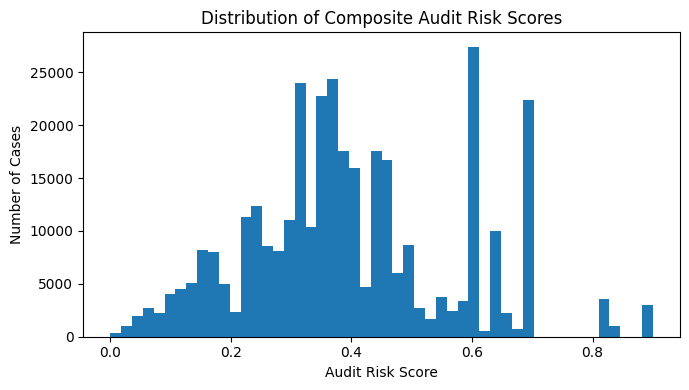

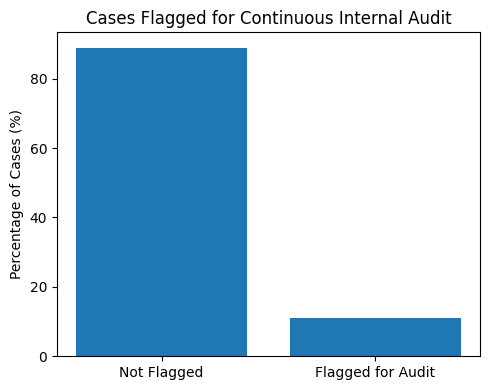

In [21]:
import matplotlib.pyplot as plt

# --- Figure 1: Audit Risk Score Distribution ---
plt.figure(figsize=(7,4))
plt.hist(df["audit_risk_score"], bins=50)
plt.xlabel("Audit Risk Score")
plt.ylabel("Number of Cases")
plt.title("Distribution of Composite Audit Risk Scores")
plt.tight_layout()
plt.savefig("fig_audit_risk_distribution.png", dpi=300)
plt.show()


# --- Figure 2: Continuous Audit Flag ---
flag_counts = df["continuous_audit_flag"].value_counts(normalize=True) * 100

plt.figure(figsize=(5,4))
plt.bar(["Not Flagged", "Flagged for Audit"],
        [flag_counts[False], flag_counts[True]])
plt.ylabel("Percentage of Cases (%)")
plt.title("Cases Flagged for Continuous Internal Audit")
plt.tight_layout()
plt.savefig("fig_continuous_audit_flag.png", dpi=300)
plt.show()
